# Obligatorio - Deep Learning

El obligatorio consiste en el diseño, entrenamiento y evaluación de Redes Generativas Adversarias (GANs) para la generación de dígitos del estilo de MNIST dataset a partir de un vector de ruido.

Integrantes del equipo:
- Carolina Allende
- Ignacio Aristimuño

## 0. Funcionamiento y utilidad de las GANs

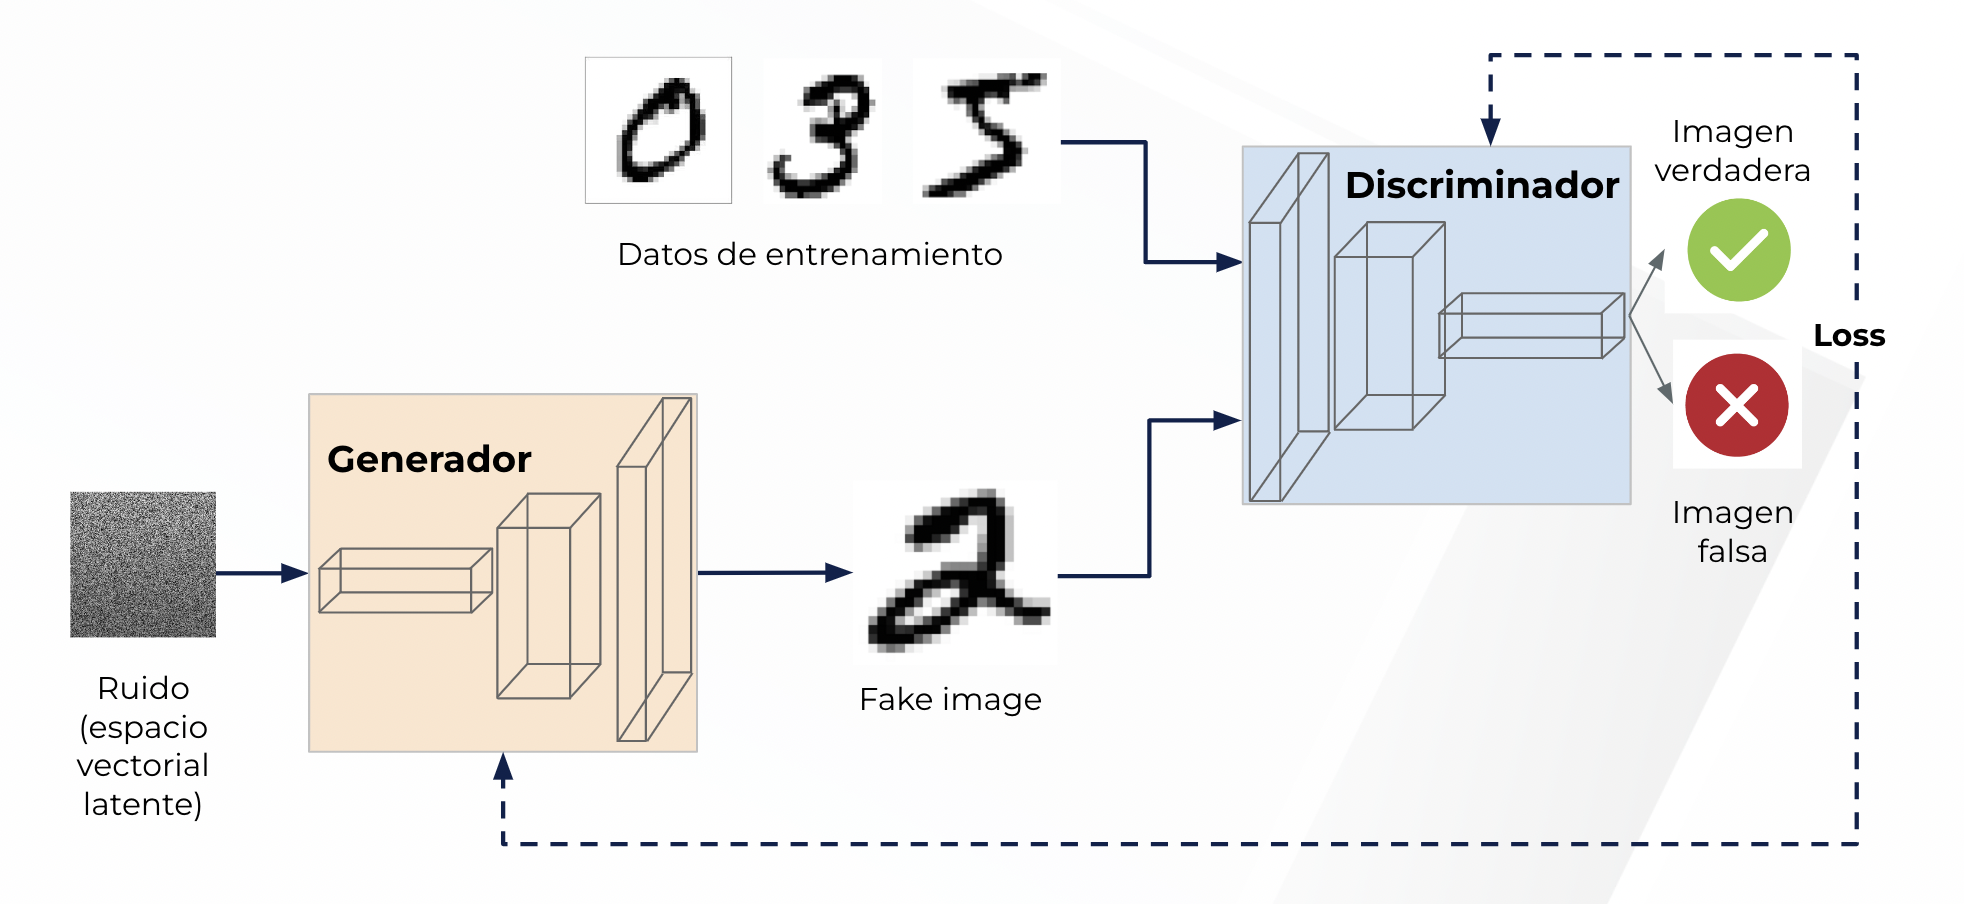

Las Generative Adversarial Networks (GANs) están compuestas de dos redes:

*   `Generador`: Este modelo recibe como input un vector de ruido y como genera como output una imagen, en el caso de este proyecto, es una imagen en escala de grises con un dígito del 0 al 9.
*   `Discriminador`: Este modelo en cambio, recibe una imagen y trata de discernir si pertenece al dataset MNIST real o si es una imagen generada por el Generador. 

El entrenamiento de estas redes se puede pensar como un juego minimax entre el generador y el discriminador: ambos modelos se entrenan simultáneamente, en donde el generador intenta maximizar su utilidad (minimizar su pérdida), mientras que el discriminador intenta minimizar la utilidad del generador. El generador toma un vector aleatorio $z$ como entrada y genera como resultado una imagen de salida $G(z)$. El discriminador, en cambio, toma como entrada o una imagen del set $G(z)$ o una imagen real del set de datos $x$ y genera una clasificación para ella, $D$, en donde se intenta clasificar dicha imagen como real o generada.

Durante el entrenamiento del discriminador los parámetros del generador se congelan, siendo el discriminador es penalizado cuando clasifica una imagen real como sintética o una sintética como real. Luego se ajustan pesos del discriminador durante la etapa de backpropagation a partir del cáculo de la función de perdida utilizada para el mismo. 

Análogamente, durante el entrenamiento del generador, los pesos del discriminador se congelan. El objetivo del generador es lograr engañar al discriminador, por lo que el generador es penalizado si el discriminador puede identificar que las imágenes generadas por el generador son falsas.

## 1. Imports y dependencias

In [1]:
#!pip install -r requirements.txt

In [2]:
import random
import os
from yaml import safe_load
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch import nn
import torch.backends.cudnn as cudnn

In [3]:
from datasets.mnist_dataset import get_mnist_dataloader
from datasets.cifar10_dataset import get_cifar_dataloader
from models.dcgan.generator import DCGANGenerator, get_dcgan_generator_defaults
from models.dcgan.discriminator import (
    DCGANDiscriminator,
    get_dcgan_discriminator_defaults,
)
from models.vanilla.generator import VanillaGenerator, get_vanilla_generator_defaults
from models.vanilla.discriminator import (
    VanillaDiscriminator,
    get_vanilla_discriminator_defaults,
)
from models.cifar10.generator import CIFARGenerator, get_cifar_generator_defaults
from models.cifar10.discriminator import (
    CIFARDiscriminator,
    get_cifar_discriminator_defaults,
)
from training import train_gan
from models.available_models import Task, GANModel

## 2. Dataset and parameters

Esta siguiente celda funciona a modo de selector de modelo a entrenar:

In [4]:
# Select which GAN to train: VANILLA_MNIST, DCGAN_MNIST or CIFAR_MNIST
model_settings = GANModel(model=Task.VANILLA_MNIST.value)

# Set random seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)

cudnn.benchmark = True

Las configuraciones generales de las redes se levantan por defecto a partir de un archivo de configuración. Para todos los casos, el discriminador y el generador tienen distintos learning rates.


In [5]:
# Settings
with open("config.yaml", "r") as file:
    settings = safe_load(file)


NOISE_DIM = settings["Generator"]["NoiseDim"]

BATCH_SIZE = settings["Dataset"]["BatchSize"]
N_WORKERS = settings["Dataset"]["Workers"]

N_EPOCHS = settings["Training"][model_settings.configs]["N_EPOCHS"]
GENERATOR_LR = settings["Training"][model_settings.configs]["GeneratorLR"]
DISCRIMINATOR_LR = settings["Training"][model_settings.configs]["DiscriminatorLR"]
ADAM_BETA_1 = settings["Training"][model_settings.configs]["AdamBeta1"]


In [6]:
# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device: {DEVICE.upper()}")

DEVICE = torch.device(DEVICE)

Current device: CPU


In [7]:
# DataLoader
if model_settings.configs == "CIFAR":
    dataloader = get_cifar_dataloader(BATCH_SIZE, N_WORKERS)
else:
    dataloader = get_mnist_dataloader(BATCH_SIZE, N_WORKERS)

## 3. Networks

### 3.1 Initialization function

Los pesos de la red se inicializan a partir de una distribución normal como planteado en [este paper](https://arxiv.org/abs/1511.06434)

In [8]:
# Weights initialization
def weights_initialization(model):
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)


### 3.2 Generator

*Vanilla GAN*


La Vanilla GAN toma como entrada ruido de dimensión noise_dim. Este ruido pasa por 4 capas $Linear$ que van aumentando el tamaño del vector hasta llevarla a una capa de salida de 728 (28x28, el tamaño de las imagenes del dataset MNIST). Las funciones de activación utilizadas son las recomendadas por [este paper](https://arxiv.org/pdf/1711.06491.pdf), donde encontraron buenos resultados empiricos para las DC GANs usando funciones de activacion SELU para las capas intermedias y tangente hiperbolica para la ultima capa


*Deep Convolutional GAN (DCGAN)*

El generador de la DCGAN toma como entrada ruido de dimension noise_dim que luego pasa por 4 capas ConvTranspose2d que aplican un kernel como una Conv2D comun, pero aumentan la dimensión de su entrada, replicando el valor del ruido ponderado por cada entrada de la matriz de kernel. Estas capas son seguidas por BatchNorm2d y funciones de activación SELU, excepto por la quinta y ultima capa ConvTranspose2D que aplica un kernel de (1,1) y lleva la imagen al tamaño de una imagen del MNIST (28x28) y a su salida se aplica una función de activación tangente hiperbolica.
Para la DC GAN, ademas del paper citado más arriba, nuestro trabajo está basado en [este tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) de Pytorch


*CIFAR 10 GAN*

El generador de esta GAN es idéntico al de la DC GAN, con la salvedad de que la dimensión de la imagen que produce es de 64x64, el tamaño de las imagenes del dataset CIFAR10

In [9]:
# Create Generator
if model_settings.model == "VANILLA_MNIST":
    generator = VanillaGenerator(**get_vanilla_generator_defaults()).to(DEVICE)
elif model_settings.model == "DCGAN_MNIST":
    generator = DCGANGenerator(**get_dcgan_generator_defaults()).to(DEVICE)
    generator.apply(weights_initialization)
elif model_settings.model == "CIFAR_MNIST":
    generator = CIFARGenerator(**get_cifar_generator_defaults()).to(DEVICE)

print(generator)

12/06/2022 09:16:31AM - VanillaGenerator - INFO: Using Vanilla Generator for MNIST


VanillaGenerator(
  (sequential): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100, out_features=256, bias=True)
    (2): SELU(inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): SELU(inplace=True)
    (5): Linear(in_features=512, out_features=1024, bias=True)
    (6): SELU(inplace=True)
    (7): Linear(in_features=1024, out_features=784, bias=True)
    (8): Tanh()
  )
)


### 3.3 Discriminator

*Vanilla GAN*


El discriminador de la Vanilla GAN consta de 3 capas Linear seguidas de SELU, y una ultima capa Linear seguida de una sigmoidea, correspondiente a la salida de una clasificación binaria. La capa de entrada es de 784, es decir, un vector de largo de 28.28 que son las dimensiones del dataset MNIST. Incluimos capas de dropout para evitar un posible sobreajuste

*DC GAN*

El discriminador de la DC GAN cuenta con 3 capas convolucionales (la primera tiene como tamaño de entrada las dimensiones de las imagenes del dataset MNIST) a las que se les aplican funciones de activación tipo LeakyRELU como sugeridas en [este paper](https://arxiv.org/pdf/1511.06434v2.pdf) y una última capa convolucional a la cual se le aplica una sigmoidea, correspondiente con una clasificación binaria. 


*CIFAR-10*

El discriminador de este modelo es igual al de la DC GAN, con la salvedad de que su input esta adaptado para las dimensiones de las imagenes del dataset CIFAR 10 

In [10]:
# Create Discriminator
if model_settings.model == "VANILLA_MNIST":
    discriminator = VanillaDiscriminator(**get_vanilla_discriminator_defaults()).to(
        DEVICE
    )
elif model_settings.model == "DCGAN_MNIST":
    discriminator = DCGANDiscriminator(**get_dcgan_discriminator_defaults()).to(DEVICE)
    discriminator.apply(weights_initialization)
elif model_settings.model == "CIFAR_MNIST":
    discriminator = CIFARDiscriminator(**get_cifar_discriminator_defaults()).to(DEVICE)

print(discriminator)

12/06/2022 09:16:33AM - VanillaDiscriminator - INFO: Using Vanilla Generator for MNIST


VanillaDiscriminator(
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): SELU(inplace=True)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): Dropout(p=0.15, inplace=False)
    (5): SELU(inplace=True)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): SELU(inplace=True)
    (9): Linear(in_features=128, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


## 4. Loss functions and optimizers

Utilizamos binary cross entropy como función de loss tanto del discriminador como  del generador en todas las GANs

Generamos un vector de ruido aleatorio fixed_noise para despues generar imagenes en cada epoca a partir del mismo ruido aleatorio y de esta forma poder ver la evolución de la generación de las imagenes conforme avanza el entrenamiento

In [11]:
# Loss function
criterion = nn.BCELoss()

# Create batch of latent vectors to keep track of training progress of the generator
fixed_noise = torch.randn(64, NOISE_DIM, 1, 1, device=DEVICE)

# Labels' convention
real_label = 1
fake_label = 0

# Optimizers
optimizerG = optim.Adam(
    generator.parameters(), lr=GENERATOR_LR, betas=(ADAM_BETA_1, 0.999)
)
optimizerD = optim.Adam(
    discriminator.parameters(), lr=DISCRIMINATOR_LR, betas=(ADAM_BETA_1, 0.999)
)

## 5. Training

### 5.1 Helper training functions

In [12]:
# Folders for saving results
RESULTS_FOLDER = f"results/{model_settings.model}"

if not os.path.isdir(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER, exist_ok=True)
if not os.path.isdir(f"{RESULTS_FOLDER}/random_results"):
    os.makedirs(f"{RESULTS_FOLDER}/random_results", exist_ok=True)
if not os.path.isdir(f"{RESULTS_FOLDER}/fixed_results"):
    os.makedirs(f"{RESULTS_FOLDER}/fixed_results", exist_ok=True)

### 5.2 Training

Por la forma en que construimos el proyecto, no es posible ver el codigo que implementa el lazo de training directamente en la notebook, por lo que sugerimos visitar el script `training.py` en la carpeta raíz de este proyecto, donde se puede ver el código en detalle.

El training comienza usando un vector de ruido aleatorio que pasa por el generador (en esta fase, sus pesos no se modifican), que retorna un set de imagenes. Estas imagenes luego pasan por el discriminador, junto con un conjunto de imagenes reales tomadas del dataset MNIST. Se calcula la perdida del discriminador y se propaga esta perdida actualizando los pesos *unicamente* del discriminador. 

Luego se generan imagenes a partir de ruido nuevamente, se pasan al discriminador unicamente estas imagenes falsas  y se computa la perdida del generador en funcion a la clasificación que el discriminador devuelva para las entradas ficticias. Luego esto se propaga *unicamente* a traves del generador, actualizando sus pesos.

Para este proyecto, actualizamos una vez los pesos de cada red para cada lazo de entrenamiento porque funcionaba correctamente, tuneando el learning rate a partir de los papers citados más arriba. Con otras configuraciones, a veces puede ser beneficioso entrenar más veces generador o discriminador. 

A continuación se muestra cómo corre la función de entrenamiento por 2 épocas a modo de ejemplificación. No obstante, se corrieron por 100 épocas aproximadamente las GANs de MNIST para ver en qué punto era óptimo el entrenamiento (comparando también las imágenes generadas). En particular para la DCGAN, se encontró que el generador tenía mayor calidad al entrenarlo entre 45 y 50 épocas, y para la GAN basada en MLPs (Vanilla) 50 épocas. Esta notebook se corrió localmente con CPU, pero el código ya tiene implementado para tomar GPU en caso de tener GPU o subirlo a Colab.

In [14]:
# Training
train_gan(
    dataloader,
    generator,
    discriminator,
    DEVICE,
    optimizerG,
    optimizerD,
    criterion,
    NOISE_DIM,
    2,
    fixed_noise,
    RESULTS_FOLDER,
)


12/06/2022 09:18:28AM - Training loop - INFO: Starting training!
  0%|                                                   | 0/938 [00:00<?, ?it/s][W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|█████████████████████████████████████████| 938/938 [01:20<00:00, 11.71it/s]
12/06/2022 09:19:48AM - Training loop - INFO: [1/2] - ptime: 80.15, loss_d: 1.330, loss_g: 0.735


saving the output


  0%|                                                   | 0/938 [00:00<?, ?it/s][W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|█████████████████████████████████████████| 938/938 [01:20<00:00, 11.62it/s]
12/06/2022 09:21:08AM - Training loop - INFO: [2/2] - ptime: 80.76, loss_d: 1.333, loss_g: 0.749


saving the output
Avg time per epoch: 160.91, total 2 total training time: 160.91
Training finish!... save training results


## 6. Results

Dentro de la función de entrenamiento en `training.py` se dejó que cada época se vayan guardando los valores de las fucniones de pérdida del generador y discriminador, y las samples del generador a partir de un mismo vector de ruido que se pasa como input en la función de training. A partir de esto es que se muestran las curvas de las losses, un ejemplo de las imágenes generadas y un gif con la evolución de ese ruido a lo largo del entrenamiento.

*Las curvas de perdida en el entrenamiento*

**DCGAN**

<center>
    <img src="images/dgcan_100_epochs.png" alt="Drawing" style="width: 500px;"/>
</center>

Idelamente en el contexto de un juego minimax, las losses deberían estabilizarse en el entorno de 0.5: el discriminador es equiprobable de clasificar una muestra como falsa que como verdadera. En la realidad, el entrenamiento es optimo cuando las funciones de pérdida del discriminador (rojo) y del generador (azul) se estabilizan, lo que se puede ver que sucede entre las épocas 40 y 50, luego de eso el modelo diverge

<center>
    <img src="images/dcgan_45_epochs.png" alt="Drawing" style="width: 500px;"/>
</center>

Gif con la evolución del entrenamiento (si no corre bien se puede copiar el markdown del fig y correrlo en una celda nueva)

![SegmentLocal](images/dcgan_training.gif "DCGAN training gif")

**Vanilla GAN (basada en MLPs)**

Con esta GAN se trabajó para tener resultados visualmente buenos, pero no se focalizó mucho en las curvas de las funciones de pérdida como en la DCGAN. 

<center>
    <img src="images/vanilla_gan_loss.png" alt="Drawing" style="width: 500px;"/>
</center>

Como se puede observar en el gráfico anterior, no se tuvo un comportamiento tan deseable como se tuvo con la DCGAN. Esto se podría atacar modificando los learning rates de las redes de forma de que, al estabilizarse, queden más cercanos los valores de las funciones de pérdida de ambas redes.

Gif con la evolución del entrenamiento (si no corre bien se puede copiar el markdown del fig y correrlo en una celda nueva)

![SegmentLocal](images/vanilla_gan.gif "Vanilla GAN training gif")

Por otro lado, al utilizarse MLPs y no capas convolucionales, hace sentido que los "defectos" en la generación de  estas imágenes sean pixeles apartados del resto del dígito. En cambio, la DCGAN al aprender sobre capas convolutivas, presenta mayor suavidad en el contorno de los dígitos.

**CIFAR GAN**

En cuanto a la GAN para el dataset de CIFAR, se comenzaron a ver resultados que estaban acercándose a los datos que se pueden observar en dicho dataset, pero no se tuvo tiempo como para iterar probando diferentes learning rates o cambios en la arquitectura como para tener buenos resultados. De todas formas, el código en el repositorio se encuentra funcional, y es cuestión de iterar un par de veces en la generación hasta converger a valores que sirvan.